<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/Image_inpaint_New_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset
import pandas as pd

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Check if dataset loaded correctly
if ds is None:
    raise ValueError("Dataset not loaded correctly")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/224 [00:00<?, ?B/s]

(…)-00000-of-00003-30fbdf94a5d8e722.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00001-of-00003-74b418aa7a721747.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00002-of-00003-4f9459a488896f53.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

In [4]:
# Modify get_dataloaders function to use a smaller subset
full_dataset = load_dataset("saitsharipov/CelebA-HQ", split='train[:1000]')  # Use only first 1000 images

Training batches: 20260
Validation batches: 2533
Test batches: 2533


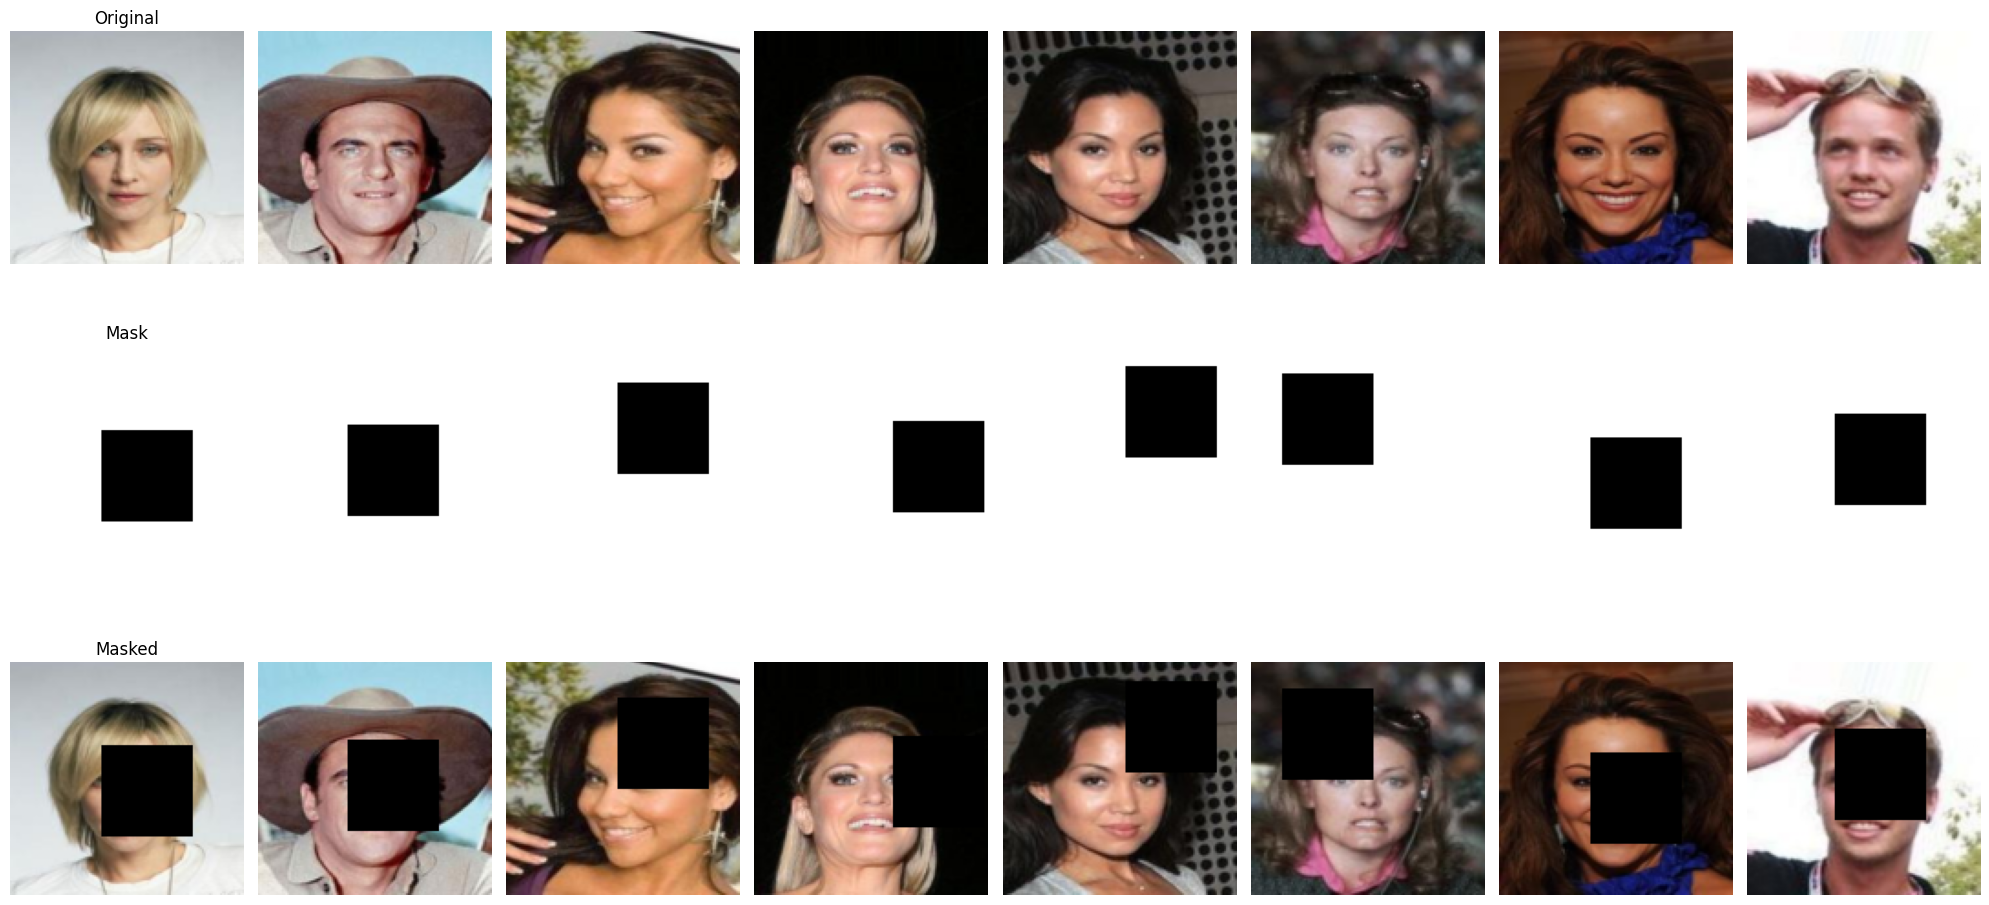

In [7]:
import torch
import torchvision.transforms as transforms
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from functools import partial

class CelebAHQDataset(Dataset):
    def __init__(self,
                 dataset,
                 img_size: int = 256,
                 mask_size: int = 100,
                 cache_size: int = 1000):
        """
        Args:
            dataset: HuggingFace dataset split
            img_size: Size to resize images to
            mask_size: Size of the square mask
            cache_size: Number of images to cache in memory
        """
        self.ds = dataset
        self.img_size = img_size
        self.mask_size = mask_size
        self.cache_size = cache_size
        self.cache = {}

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self) -> int:
        return len(self.ds)

    def create_mask(self) -> torch.Tensor:
        """Creates a random square mask efficiently"""
        mask = torch.ones(3, self.img_size, self.img_size)
        top = torch.randint(0, self.img_size - self.mask_size, (1,)).item()
        left = torch.randint(0, self.img_size - self.mask_size, (1,)).item()
        mask[:, top:top+self.mask_size, left:left+self.mask_size] = 0
        return mask

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Try to get from cache first
        if idx in self.cache:
            image = self.cache[idx]
        else:
            # Load and transform image
            image = self.transform(self.ds[idx]['image'])

            # Update cache
            if len(self.cache) < self.cache_size:
                self.cache[idx] = image

        # Create mask and masked image efficiently
        mask = self.create_mask()
        masked_image = image * mask

        return image, masked_image, mask

def get_dataloaders(batch_size: int = 32,
                    img_size: int = 256,
                    mask_size: int = 100,
                    num_workers: int = 4,
                    cache_size: int = 1000) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates train, validation, and test dataloaders efficiently
    """
    # Load the full dataset
    full_dataset = load_dataset("saitsharipov/CelebA-HQ", split='train')

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Split the dataset
    train_data, val_data, test_data = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create dataset instances
    train_dataset = CelebAHQDataset(train_data, img_size, mask_size, cache_size)
    val_dataset = CelebAHQDataset(val_data, img_size, mask_size, cache_size)
    test_dataset = CelebAHQDataset(test_data, img_size, mask_size, cache_size)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True
    )

    return train_loader, val_loader, test_loader

def visualize_batch(dataloader: DataLoader, num_images: int = 8) -> None:
    """Visualize a batch of images with their masks and masked versions"""
    images, masked_images, masks = next(iter(dataloader))
    images, masked_images, masks = images[:num_images], masked_images[:num_images], masks[:num_images]

    fig, axes = plt.subplots(3, num_images, figsize=(20, 10))

    for i in range(num_images):
        # Use consistent normalization for better visualization
        axes[0, i].imshow(images[i].permute(1, 2, 0).clip(0, 1))
        axes[1, i].imshow(masks[i].permute(1, 2, 0).mean(dim=2), cmap='gray')
        axes[2, i].imshow(masked_images[i].permute(1, 2, 0).clip(0, 1))

        for ax in axes[:, i]:
            ax.axis('off')

    titles = ['Original', 'Mask', 'Masked']
    for ax, title in zip(axes[:, 0], titles):
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Configuration
    CONFIG = {
        'batch_size': 8,
        'img_size': 128,
        'mask_size': 50,
        'num_workers': 2,
        'cache_size': 100
    }

    # Get dataloaders
    train_loader, val_loader, test_loader = get_dataloaders(**CONFIG)

    # Print dataset information
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Visualize a batch
    visualize_batch(train_loader)

In [9]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    scaler = GradScaler()

    for epoch in range(num_epochs):
        for batch in progress_bar:
            with autocast():
                outputs = model(masked_images, masks)
                loss = criterion(outputs, images)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()